In [97]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [99]:
cd /content/drive/MyDrive/機械学習関連/自己研鑽/機械学習を解釈する技術

/content/drive/MyDrive/機械学習関連/自己研鑽/機械学習を解釈する技術


# 4 特徴量と予測値の関係を知る〜Partial Dependence〜

**PFI**は、マクロな視点の解釈手法であり、ファーストステップとしてモデルの振る舞いの外観をつかむ（ブラックボックスモデルに対して**特徴量の重要度**という解釈性を与える）のに適している。  
ある特徴量が大きくなったときに、モデルは大きい値を予測するようになるのか？小さい値を予測するようになるのかの関係性はわからない。


**Partial Dependence （PD）**を用いることにより、特徴量と予測値の関係の大枠を捉えることができる。

*   モデルのデバッグ（想定とは逆の関係性が出力された場合に、データのバグを疑う。アイスと気温の売り上げで負の関係が出力される等）
*   特徴量と予測値の関係からアクションに繋がる仮説を構築（モデルに含まれる操作可能な変数を調整することでKPI（売り上げ向上など）を向上させる。）

※PDで解釈された関係は、必ずしも因果関係を意味しない！あくまで因果関係の仮説を立てるために利用する。



## 線形の場合
Y = X + ε  
X ~ Uniform(0,1)  
ε~ N(0, 0.01)

In [2]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 67.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=9d4a1cb423a1f8ee76904c7711fde74b403a739ea47cf5e3a7ea3a442736e59d
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize_matplotlib


In [3]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any  # 型ヒント用
from __future__ import annotations  # 型ヒント用

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # matplotlibの日本語表示対応

# # 自作モジュール
# sys.path.append("..")
# from mli.visualize import get_visualization_setting

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
# sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")  # warningsを非表示に

In [48]:
from sklearn.model_selection import train_test_split


def generate_simulation_data1():
    """シミュレーション1のデータを生成"""

    N = 1000  # インスタンス数
    beta = np.array([1])  # 回帰係数

    X = np.random.uniform(0, 1, [N, 1])  # 一様分布から特徴量を生成
    epsilon = np.random.normal(0, 0.1, N)  # 正規分布からノイズを生成
    y = X @ beta + epsilon  # 線形和で目的変数を作成

    return train_test_split(X, y, test_size=0.2, random_state=42)


# シミュレーションデータの生成
X_train, X_test, y_train, y_test = generate_simulation_data1()

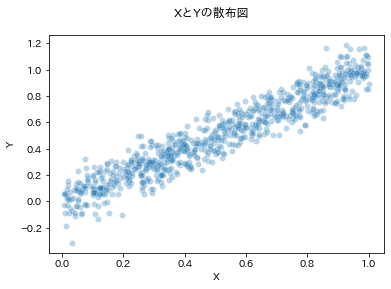

In [49]:
def plot_scatter(x, y, xlabel="X", ylabel="Y", title=None):
    """散布図を作成"""
    
    fig, ax = plt.subplots()
    sns.scatterplot(x, y, ci=None, alpha=0.3, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)
    fig.show()


#　特徴量Xと目的変数Yの散布図を作成 
plot_scatter(X_train[:, 0], y_train, title="XとYの散布図")

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# 2.3節で作成した精度評価関数
# from mli.metrics import regression_metrics


# 線形回帰モデルの学習
lm = LinearRegression().fit(X_train, y_train)

# R2とRMSEの算出
print('R2:', lm.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, lm.predict(X_test))))

R2: 0.9074456353175551
RMSE: 0.0932056840279444


In [51]:
# 切片と特徴量Xの回帰係数を確認
# 偏回帰係数
print(pd.DataFrame({"Name":['X'],
                    "Coefficients":lm.coef_}).sort_values(by='Coefficients') )

print('切片：',lm.intercept_)

  Name  Coefficients
0    X          1.01
切片： -0.012781859401839735


線形の場合は、線形回帰モデルで特徴量とモデルの予測値の関係を明示的に解釈できる。

## 非線形の場合
Y = 10sin(X0) + X1 + ε  
X0 ~ Uniform(-2π,2π)  
X1 ~ Uniform(-2π,2π)  
ε~ N(0, 0.01)

In [52]:
def generate_simulation_data2():
    """シミュレーション2のデータを生成"""

    N = 1000  # インスタンス数

    # 一様分布から特徴量を生成
    X = np.random.uniform(-np.pi * 2, np.pi * 2, [N, 2])
    epsilon = np.random.normal(0, 0.1, N)  # 正規分布からノイズを生成

    # 特徴量X0はsin関数で変換する
    y = 10 * np.sin(X[:, 0]) + X[:, 1] + epsilon

    return train_test_split(X, y, test_size=0.2, random_state=42)


# シミュレーションデータの生成
X_train, X_test, y_train, y_test = generate_simulation_data2()

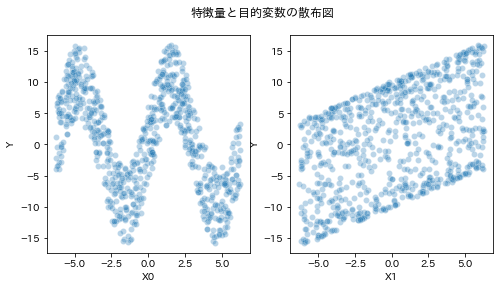

In [53]:
def plot_scatters(X, y, var_names, title=None):
    """目的変数と特徴量の散布図を作成"""
    
    # 特徴量の数だけ散布図を作成
    J = X.shape[1]
    fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(4 * J, 4))

    for j, ax in enumerate(axes):
        sns.scatterplot(X[:, j], y, ci=None, alpha=0.3, ax=ax)
        ax.set(
            xlabel=var_names[j], 
            ylabel="Y", 
            xlim=(X.min() * 1.1, X.max() * 1.1)
        )
    fig.suptitle(title)
    
    fig.show()


# 特徴量ごとに目的変数との散布図を作成
plot_scatters(
    X_train, y_train, ["X0", "X1"], title="特徴量と目的変数の散布図"
)

In [54]:
# モデルの学習
lm = LinearRegression().fit(X_train, y_train)

# R2とRMSEの算出
print('R2:', lm.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, lm.predict(X_test))))

R2: 0.2642671777542738
RMSE: 6.9453825604193655


In [55]:
# 切片と特徴量X0, X1の回帰係数を確認
print(pd.DataFrame({"Name":['X0', 'X1'],
                    "Coefficients":lm.coef_}).sort_values(by='Coefficients') )

print('切片：',lm.intercept_)

  Name  Coefficients
0   X0         -0.71
1   X1          0.92
切片： 0.5414641879771496


目的変数Yと非線形な関係を持つ特徴量X0は、Yとの関係をうまく学習できていない。

In [56]:
from sklearn.ensemble import RandomForestRegressor


# Random Forestによる予測モデルの構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

# 予測精度の確認
print('R2:', rf.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf.predict(X_test))))

R2: 0.9941564012009618
RMSE: 0.6189795519045754


### Partial Dependenceを用いて解釈

In [57]:
# インスタンス0を取り出す
i = 0
Xi = X_test[[i]]

# 特徴量を出力
Xi

array([[-2.06720918,  3.71826885]])

In [59]:
# インスタンス0に対する予測値
print(f"(X0, X1)=(-2.07, 3.72)のときの予測値：{rf.predict(Xi)[0]:.2f}")

(X0, X1)=(-2.07, 3.72)のときの予測値：-5.17


In [62]:
def counterfactual_prediction(
    estimator, X, idx_to_replace, value_to_replace
):
    """ある特徴量の値を置き換えたときの予測値を求める

    Args:
        estimator: 学習済みモデル
        X: 特徴量
        idx_to_replace: 値を置き換える特徴量のインデックス
        value_to_replace: 置き換える値
    """
    
    # 特徴量の値を置き換える際に、元の特徴量が上書きされないよう用にコピーしておく
    X_replaced = X.copy()

    # 特徴量の値を置き換えて予測
    X_replaced[:, idx_to_replace] = value_to_replace
    y_pred = estimator.predict(X_replaced)

    return y_pred


# X0の値を-4に置き換えた場合の予測値
cp = counterfactual_prediction(rf, Xi, 0, -4)[0]
print(f"(X0, X1)=(-4, 2.15)のときの予測値：{cp:.2f}")

(X0, X1)=(-4, 2.15)のときの予測値：11.28


X0の値を−2から−4まで小さくした場合に、予測値は−5.17から11.28まで大きくなった。

In [69]:
# X0の値を-3置き換えた場合の予測値を出力
cp = counterfactual_prediction(rf, Xi, 0, -1.5)[0]
print(f"(X0, X1)=(-3, 2.15)のときの予測値：{cp:.2f}")

(X0, X1)=(-3, 2.15)のときの予測値：-5.83


X0の値を−2から−1.5まで大きくした場合に、予測値は−5.17から-5.83まで小さくなった。

In [70]:
# X0の取りうる範囲を50個に分割
X0_range = np.linspace(-np.pi * 2, np.pi * 2, num=50)

# 取りうる範囲でX0の値を動かして予測値を生成
cps = np.concatenate(
    [counterfactual_prediction(rf, Xi, 0, x) for x in X0_range]
)
cps

array([ 5.32441   ,  6.49724107,  8.14201174, 11.10569927, 12.20681429,
       13.32477558, 13.32821971, 13.17829317, 12.67661764, 10.93554066,
        8.23891059,  7.23894338,  4.9490491 ,  1.95777766, -0.73402686,
       -3.75331503, -4.78840487, -5.52734721, -5.86442863, -5.80088433,
       -5.45079621, -4.71861578, -2.36711896,  0.99612811,  2.68818438,
        4.84830691,  8.16155372, 10.59781148, 11.66010696, 12.78818435,
       13.07464295, 13.19724693, 12.96950524, 12.44557889, 10.67605415,
        7.85653569,  5.64457599,  2.45457577,  0.15968872, -1.29503301,
       -4.55129269, -5.29081559, -5.78185024, -5.88903368, -5.69192119,
       -5.07447444, -4.0735375 , -1.27373647,  2.1359587 ,  2.94714129])

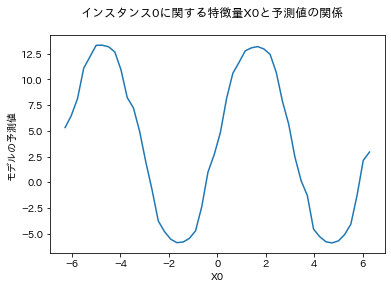

In [71]:
def plot_line(x, y, xlabel="X", ylabel="Y", title=None):
    """特徴量の値を変化させた場合の予測値の推移を可視化"""
    
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)
    
    fig.show()

    
# 可視化
plot_line(
    X0_range, 
    cps, 
    "X0", 
    "モデルの予測値", f"インスタンス{i}に関する特徴量X0と予測値の関係"
)

目的変数Yと特徴量X0との非線形の関係を明快に見てとることができる.  
Y=12.5sin(X0)のような形をしている。

In [83]:
# インスタンス20を取り出す。
i = 20
Xi = X_test[[i]]

# 特徴量を出力
Xi

array([[ 0.06784964, -4.59377368]])

In [84]:
# インスタンス20に対する予測値
print(f"(X0, X1)=(4.38, 3.8)のときの予測値：{rf.predict(Xi)[0]:.2f}")

(X0, X1)=(4.38, 3.8)のときの予測値：-2.84


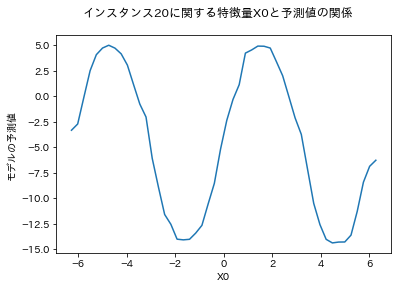

In [85]:
# インスタンス20についてもX0の値を動かして予測値を生成
cps = np.concatenate(
    [counterfactual_prediction(rf, Xi, 0, x) for x in X0_range]
)

# 可視化
plot_line(
    X0_range, 
    cps, 
    "X0",
    "モデルの予測値",
    f"インスタンス{i}に関する特徴量X0と予測値の関係"
)

目的変数Yと特徴量X0との非線形の関係を明快に見てとることができる.  
Y=5sin(X0)のような形をしている。

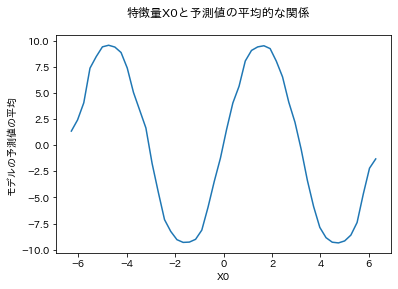

In [86]:
# すべてのインスタンスに対して予測値を出し、インスタンスごとの結果を平均する
avg_cps = np.array(
    [counterfactual_prediction(rf, X_test, 0, x).mean() for x in X0_range]
)

# 可視化
plot_line(
    X0_range,
    avg_cps,
    "X0",
    "モデルの予測値の平均",
    "特徴量X0と予測値の平均的な関係"
)

このように「他の特徴量を固定して興味のある特徴量だけを動かし、各インスタンスの予測値を平均して可視化する」解釈手法を**Partial Dependence(PD)**という。

### Partial Dependenceクラスの実装

In [87]:
@dataclass
class PartialDependence:
    """Partial Dependence (PD)

    Args:
        estimator: 学習済みモデル
        X: 特徴量
        var_names: 特徴量の名前
    """
    
    estimator: Any
    X: np.ndarray
    var_names: list[str]
    
    def _counterfactual_prediction(
        self,
        idx_to_replace: int,
        value_to_replace: float
    ) -> np.ndarray:
        """ある特徴量の値を置き換えたときの予測値を求める

        Args:
            idx_to_replace: 値を置き換える特徴量のインデックス
            value_to_replace: 置き換える値
        """

        # 特徴量の値を置き換える際、元データが上書きされないようコピー
        X_replaced = self.X.copy()

        # 特徴量の値を置き換えて予測
        X_replaced[:, idx_to_replace] = value_to_replace
        y_pred = self.estimator.predict(X_replaced)

        return y_pred

    def partial_dependence(
        self,
        var_name: str,
        n_grid: int = 50
    ) -> None:
        """PDを求める

        Args:
            var_name: 
                PDを計算したい特徴量の名前
            n_grid: 
                グリッドを何分割するか
                細かすぎると値が荒れるが、粗すぎるとうまく関係を捉えられない
                デフォルトは50
        """
        
        # 可視化の際に用いるのでターゲットの変数名を保存
        self.target_var_name = var_name  
        # 変数名に対応するインデックスをもってくる
        var_index = self.var_names.index(var_name)

        # ターゲットの変数を、取りうる値の最大値から最小値まで動かせるようにする
        value_range = np.linspace(
            self.X[:, var_index].min(), 
            self.X[:, var_index].max(), 
            num=n_grid
        )

        # インスタンスごとのモデルの予測値を平均
        average_prediction = np.array([
            self._counterfactual_prediction(var_index, x).mean()
            for x in value_range
        ])

        # データフレームとしてまとめる
        self.df_partial_dependence = pd.DataFrame(
            data={var_name: value_range, "avg_pred": average_prediction}
        )

    def plot(self, ylim: list[float] | None = None) -> None:
        """PDを可視化

        Args:
            ylim: 
                Y軸の範囲
                特に指定しなければavg_predictionの範囲となる
                異なる特徴量のPDを比較したいときなどに指定する
        """

        fig, ax = plt.subplots()
        ax.plot(
            self.df_partial_dependence[self.target_var_name],
            self.df_partial_dependence["avg_pred"],
        )
        ax.set(
            xlabel=self.target_var_name,
            ylabel="Average Prediction",
            ylim=ylim
        )
        fig.suptitle(f"Partial Dependence Plot ({self.target_var_name})")
        
        fig.show()

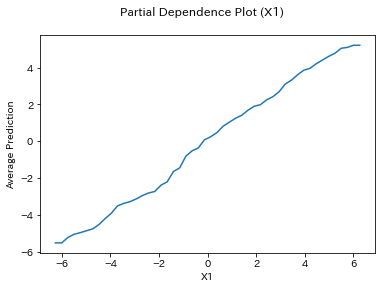

In [94]:
# PDのインスタンスを作成
# pandasとかぶるので、変数名はpdではなくpdp(partial dependence plot)とした
pdp = PartialDependence(rf, X_test, ["X0", "X1"])

# X1に対するPDを計算
pdp.partial_dependence("X1", n_grid=50)

# PDを可視化
pdp.plot()

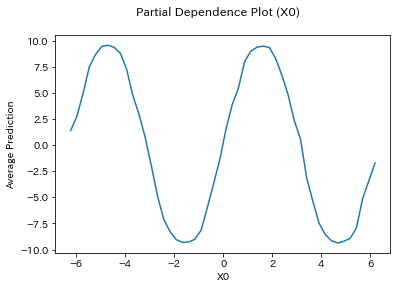

In [95]:
# X0に対するPDを計算
pdp.partial_dependence("X0", n_grid=50)

# PDを可視化
pdp.plot()

Partial Dependenceは、特徴量X0とX1の両方ともモデルの予測値との関係をうまく捉えることができている

### Partial Dependenceの数式表現

p.111-113参照.  
コードと数式の両面から解釈手法を見ていくことで、この解釈手法に対してより深く理解できる。

## PDを使うメリット（散布図を用いた解釈との比較）


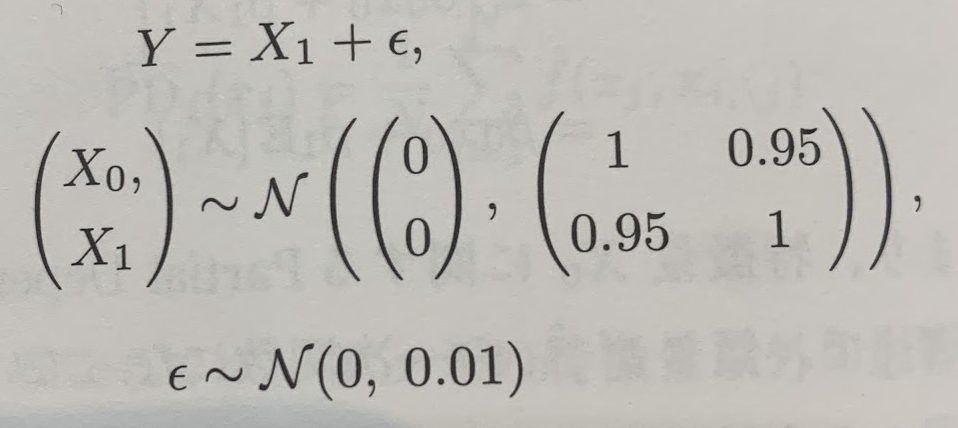

In [108]:
from IPython.display import Image
Image('image/ch4_1.png', width=300)

In [96]:
def generate_simulation_data3():
    """シミュレーション3のデータを生成"""

    N = 1000  # インスタンス数
    beta = np.array([0, 1])  # 回帰係数

    # 多変量正規分布から強く相関するデータを生成
    mu = np.array([0, 0])
    Sigma = np.array([[1, 0.95], [0.95, 1]])
    X = np.random.multivariate_normal(mu, Sigma, N)
    epsilon = np.random.normal(0, 0.1, N)  # 正規分布からノイズを生成
    y = X @ beta + epsilon  # 線形和で目的変数を作成

    return train_test_split(X, y, test_size=0.2, random_state=42)


# シミュレーションデータの生成
X_train, X_test, y_train, y_test = generate_simulation_data3()

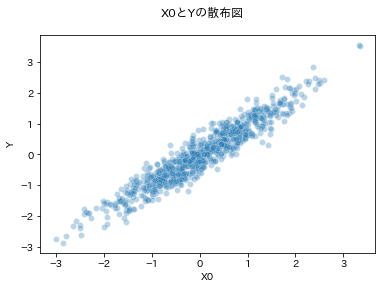

In [109]:
# 散布図を作成
plot_scatter(X_train[:, 0], y_train, xlabel="X0", title="X0とYの散布図")

散布図をみると、特徴量X0と目的変数Yには正の相関があるように見える.  
実際は、「特徴量X1と目的変数Yに正の相関があり、特徴量X0と特徴量X1に正の相関があるため、結果として特徴量X0と目的変数に正の相関がある」

In [111]:
# モデルの学習
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

# 予測精度の確認
print('R2:', rf.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf.predict(X_test))))

R2: 0.9807936758448348
RMSE: 0.14935264884234345


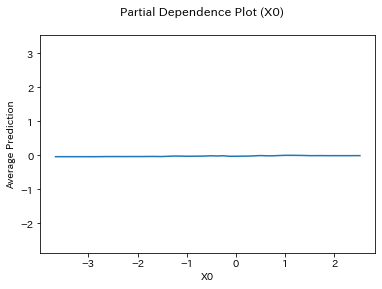

In [112]:
# PDのインスタンスを作成
pdp = PartialDependence(rf, X_test, ["X0", "X1"])

# X0に対するPDを計算
pdp.partial_dependence("X0", n_grid=50)

# PDを可視化
pdp.plot(ylim=(y_train.min(), y_train.max()))

特徴量X0はモデルの予測にほとんど影響を与えていないことがわかる。  
->特徴量(X0, X1)を共にモデリングし、モデルを通してPDで結果を解釈することで、特徴量X0と目的変数Yに正の相関があるという間違った解釈を避けることができる。

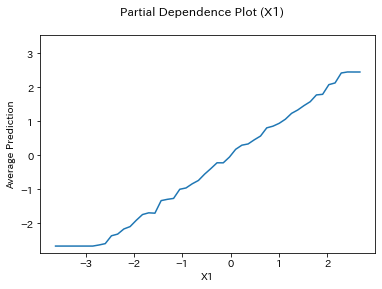

In [113]:
# X1に対するPDを計算、可視化
pdp.partial_dependence("X1", n_grid=50)
pdp.plot(ylim=(y_train.min(), y_train.max()))

## PDを因果関係として解釈することの危険性

X1を取り込まずにX0のみで学習させる

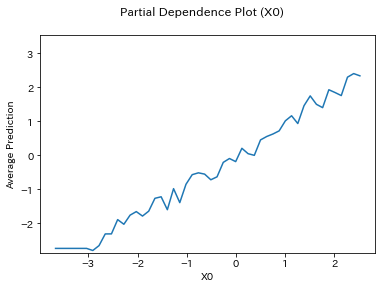

In [115]:
# モデルの学習
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train[:, [0]], y_train)

# PDのインスタンスを作成
pdp = PartialDependence(rf, X_test[:, [0]], ["X0"])

# X0に対するPDを計算
pdp.partial_dependence("X0", n_grid=50)

# PDを可視化
pdp.plot(ylim=(y_train.min(), y_train.max()))

In [118]:
# 予測精度の確認
print('R2:', rf.score(X_test[:,[0]], y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf.predict(X_test[:,[0]]))))

R2: 0.8770374078726401
RMSE: 0.37790036129078763


PDでも、X0が目的変数Yと正の相関を持つと解釈されてしまう.  
PDを因果関係として解釈できるかどうかは、モデルが特徴量と目的変数の関係をうまく捉えられているかに依存する。  
**PDの結果を盲目的に因果関係として解釈するのは危険！！**

## 実データでの分析

### PDによる可視化

In [120]:
import joblib

# データと学習済みモデルを読み込む
X_train, X_test, y_train, y_test = joblib.load("boston_housing.pkl")
rf = joblib.load("boston_housing_rf.pkl")

In [121]:
from sklearn.inspection import partial_dependence


# PDを計算
pdp = partial_dependence(
    estimator=rf,  # 学習済みモデル
    X=X_test,  # PDを計算したいデータ
    features=["RM"],  # PDを計算したい特徴量
    kind="average",  # PDは"average"、ICEは"individual"、両方は"both"
)
pdp

{'average': array([[18.66547229, 18.57526133, 18.56737376, 18.54758385, 18.3557727 ,
         18.52827679, 18.53226078, 18.54175193, 18.54552367, 18.54588063,
         18.54662548, 18.55045122, 18.55085761, 18.55495458, 18.54702239,
         18.64160021, 18.64353251, 18.58288335, 18.67271398, 18.67271398,
         18.67789295, 18.95742257, 18.96943722, 19.11834056, 19.10607532,
         19.12118527, 19.12879441, 19.12732714, 19.123495  , 19.12689931,
         19.13831759, 19.15118039, 19.17665401, 19.17552648, 19.20053275,
         19.21520746, 19.23094474, 19.23320045, 19.23219859, 19.23316058,
         19.2110902 , 19.20710238, 19.20476529, 19.19190103, 19.32569873,
         19.32573341, 19.9018527 , 19.94187968, 20.01937062, 20.03393345,
         20.03379949, 20.02617008, 20.02465524, 20.02805844, 20.02988654,
         20.02895378, 20.03337274, 20.02074318, 20.05631722, 20.06278711,
         20.11396812, 20.11265297, 20.12037627, 20.16133279, 20.17429266,
         20.19522938, 20.17

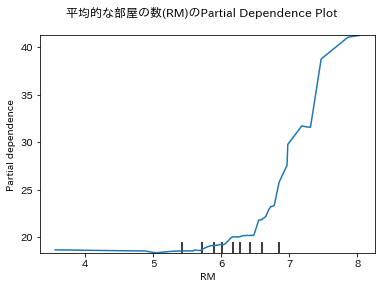

In [122]:
from sklearn.inspection import plot_partial_dependence


# 何度か使うのでplot_partial_dependence()を利用した関数を作成しておく
def plot_boston_pd(var_name, var_name_jp):
    """PDを可視化する関数"""

    fig, ax = plt.subplots()
    plot_partial_dependence(
        estimator=rf,  # 学習済みモデル
        X=X_test,  # PDを計算したいデータ
        features=[var_name],  # PDを計算したい特徴量
        kind="average",  # PDは"average"、ICEは"individual"、両方は"both"
        ax=ax,
    )
    fig.suptitle(f"{var_name_jp}({var_name})のPartial Dependence Plot")

    fig.show()


plot_boston_pd("RM", "平均的な部屋の数")

RMは６部屋までは住宅価格の予測値に影響を与えないが、6から8の間では、部屋数が大きくなると住宅価格が大きくなる。全体として非線形の関係を捉えられている。  
   
※棒グラフは、どこにデータが密集しているかを示している。

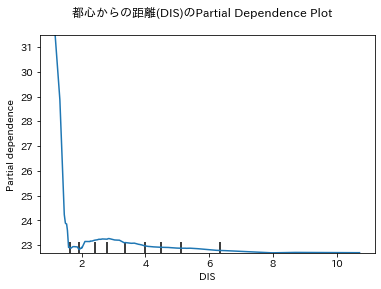

In [123]:
# DISについてもPDを可視化
plot_boston_pd("DIS", "都心からの距離")

都心から離れると予測値が小さくなる傾向。

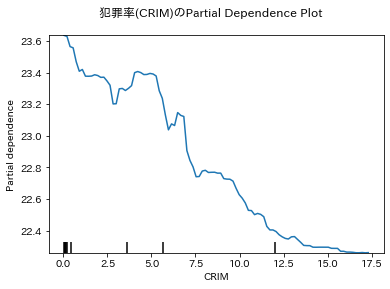

In [125]:
# CRIMについてもPDを可視化
plot_boston_pd("CRIM", "犯罪率")

犯罪率が高いほど、予測値が小さくなる傾向

### 散布図による可視化

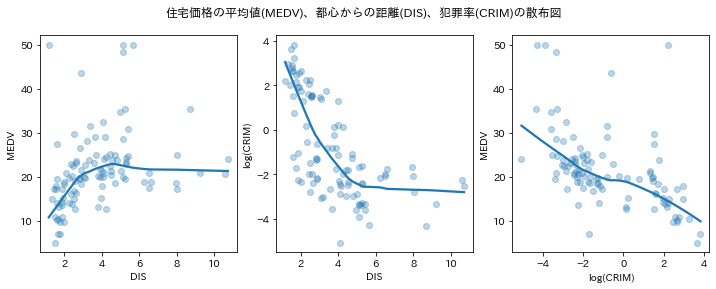

In [126]:
from functools import partial


def plot_lowess():
    """MEDV, DIS, CRIMの関係を散布図とLOWESSで可視化"""

    # LOWESSによる回帰曲線を追加した散布図
    lowess_plot = partial(
        sns.regplot,
        lowess=True,
        ci=None,
        scatter_kws={"alpha": 0.3}
    )

    # 3つの散布図を並べて可視化
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

    # 都心からの距離と住宅価格
    lowess_plot(x=X_test["DIS"], y=y_test, ax=axes[0])
    axes[0].set(xlabel="DIS", ylabel="MEDV")

    # 都心からの距離と犯罪率（対数）
    lowess_plot(x=X_test["DIS"], y=np.log(X_test["CRIM"]), ax=axes[1])
    axes[1].set(xlabel="DIS", ylabel="log(CRIM)")

    # 犯罪率（対数）と住宅価格
    lowess_plot(x=np.log(X_test["CRIM"]), y=y_test, ax=axes[2])
    axes[2].set(xlabel="log(CRIM)", ylabel="MEDV")

    fig.suptitle("住宅価格の平均値(MEDV)、都心からの距離(DIS)、犯罪率(CRIM)の散布図")
    
    fig.show()
    
    
plot_lowess()

ただの散布図だと、DISと住宅価格の関係は、正の関係（都心からの距離が離れるほど、住宅価格が上昇）になっている。  
->散布図では都心からの距離が離れるほど、CRIMの値が小さくなるために住宅価格が上昇するという背後の関係を読み取れていない。

# 4章まとめ

## PDの利点


*   どんな機械学習モデルに対しても、同じやり方で特徴量とモデルの予測値の平均的な関係を計算可能
*   PDを確認することで、**それぞれの特徴量がモデルの予測値にどのように影響を与えているのかを確認できる**。
*   予測モデルとしてブラックボックスモデルを採用できるので、**特徴量と目的変数の非線形な関係をある程度自動的に考慮できる**
*   特徴量と目的変数の一対一の関係だけでなく、**他の特徴量の影響を考慮に入れることができる。**




## PDを扱う注意点


*   あくまで特徴量とモデルの予測値の関係を表現していることに注意
*   特徴量とモデルの予測値の平均的な関係を表現していることに注意（インスタンスごとに特徴量とモデルの予測値が異なっても、その影響を無視してしまう）->5章でここを解釈できる手法を学ぶ

